In [2]:
from __future__ import print_function
import numpy as np
import tables as tb
%matplotlib inline
import matplotlib.pyplot as plt
import time

import sensorFunctions as sns
print("This notebook has been run last on {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

This notebook has been run last on 01/11/2016 at 23:45:29.


In [3]:
try:
    h5f.close()
except:
    pass

In [4]:
h5f = tb.open_file("/Users/Gonzalo/github/IC/data/run_2639.h5")
pmtcwf = h5f.root.RD.pmtrwf
pmtdf = sns.read_data_sensors(h5f.root.Sensors.DataPMT)

In [5]:
def compute_wf_rms(wf, n_loops=1):
    """
    Compute the RMS of the waveform recursively removing possible
    signal-like structures.
    
    Parameters
    ----------
    wf : ndarray
        Waveform to which the RMS is computed
    n_loops : int
        Number of recursive steps
        
    Returns
    -------
    rms : float
        Value of the rms
    """
    if n_loops == 0:
        return np.std(wf)
    
    mean_ = np.mean(wf)
    rms_ = np.std(wf)
    masked_wf = np.ma.masked_greater(wf, mean_+3*rms_)
    return compute_wf_rms(masked_wf, n_loops-1)


def compute_rms_dataset(evts, sample_size=1000, n_loops=1):
    """
    Analyze a dataset to extract the RMS (noise).
    
    Parameters
    ----------
    evts : ndarray
        Array containing the wf (axis 2) for each sensor (axis 1)
        and event (axis 0).
    window_size : int
        Size of the sample to be taken for measuring the RMS.
    n_loops : int
        Number of loops for the RMS calculation.
        
    Returns
    -------
    pmt_rms : ndarray
        RMS of each PMT (axis 0) for each event (axis 1)
    sum_rms : ndarray
        RMS of the PMT sum for each event (axis 0)
    """
    compute_rms = lambda x: compute_wf_rms(x, n_loops)
    
    pmt_rms, sum_rms = [], []
    for evt in evts:
        samples = evt[:,:sample_size]
        pmt_rms.append(np.apply_along_axis(compute_rms, 1, samples))
        sum_rms.append(compute_rms(samples.sum(axis=0)))
    return np.array(pmt_rms).T, np.array(sum_rms)

def control_plots(pmt_rms, sum_rms, pmtdf, log_scale=False):
    """
    Create control plots to ensure data is valid.
    """
    fig = plt.figure(figsize=(5,4))
    with sum_rms as data:
        low = np.min(data)
        upp = np.mean(data) + 0.1*np.std(data)
        h = plt.hist(data, 100, range=(low,upp))
        plt.text((low+upp)/2, np.max(h[0])/2, 'mean = {:.4f} pes\npeak = {:.4f} pes'.format(np.mean(data), h[1][np.argmax(h[0])]))
        plt.xlabel("Waveform RMS (pes)")
        plt.ylabel("Entries")
        plt.title("PMT sum")
        if log_scale:
            plt.yscale('log')


    fig, axes = plt.subplots(4,3)
    axes = axes.flatten()
    fig.set_size_inches(10,8)
    for i, data in enumerate(pmt_rms):
        low = np.min(data)
        upp = np.mean(data) + 0.5*np.std(data)
        h = axes[i].hist(data, 100, range=(low,upp))
        if log_scale:
            plt.yscale('log')
        axes[i].text(low-(low-upp)/3, np.max(h[0])/2, 'mean = {:.4f} adc\npeak = {:.4f} adc'.format(np.mean(data), h[1][np.argmax(h[0])]))
        axes[i].set_xlabel("Waveform RMS (adc)")
        axes[i].set_ylabel("Entries")
        axes[i].set_title("PMT " + str(pmtdf['channel'][i]))
    plt.tight_layout()

def create_rms_table(run_file, out_file, window_size=1000, n_loops=1, confirm=True):
    """
    Creates a new file holding the copy of the DataPMT table with the
    noise_rms column modified according to the new computed values.
    """
    with tb.open_file(run_file) as h5in:
        datapmt_in = h5in.root.Sensors.DataPMT
        pmt_wfs = h5in.root.RD.pmtcwf
        
        pmt_rms, sum_rms = compute_rms_dataset(pmt_wfs, window_size, n_loops)
        if confirm:
            control_plots(pmt_rms, sum_rms, sns.read_data_sensors(datapmt_in))
            confirmation = raw_input("Confirm (y/[n]): ")
            if confirmation == "y":
                print("Writing noise_rms constants to", out_file)
            else:
                print("Aborted")
        with tb.open_file(out_file,"w") as h5out:
            datapmt_out = datapmt_in.copy(newparent=h5out.root)
            datapmt_out.cols.noise_rms[:] = pmt_rms
            datapmt_out.flush()

### Histograms of the RMS for each PMT and for the sum

In [6]:
pmt_rms, sum_rms = compute_rms_dataset(pmtcwf, 48000, 0)

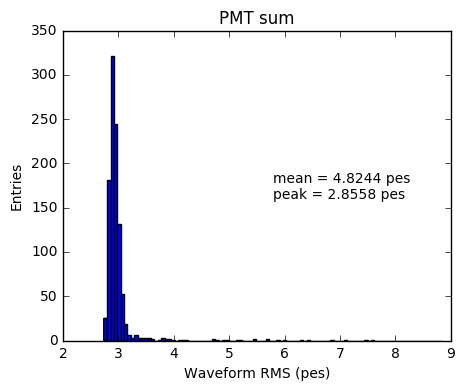

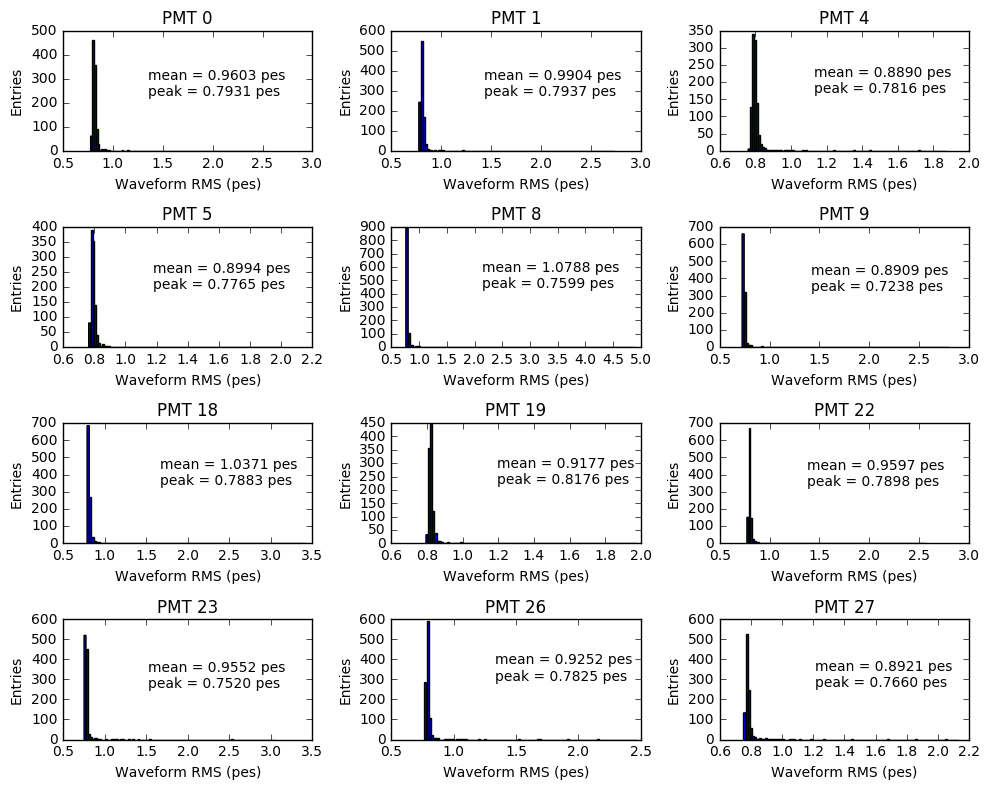

### A plot of the RMS vs the event
In some cases there is signal-like structures in the waveform.

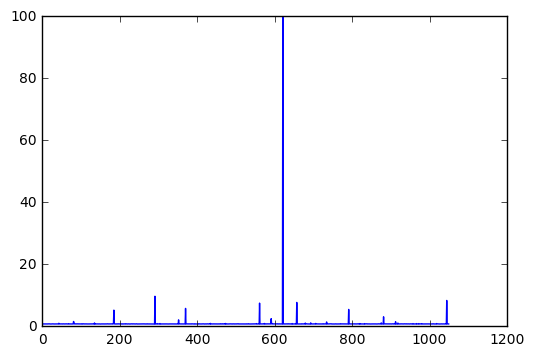

In [26]:
plt.plot(pmt_rms[0])

#### A case where a signal like event disturbs the RMS.

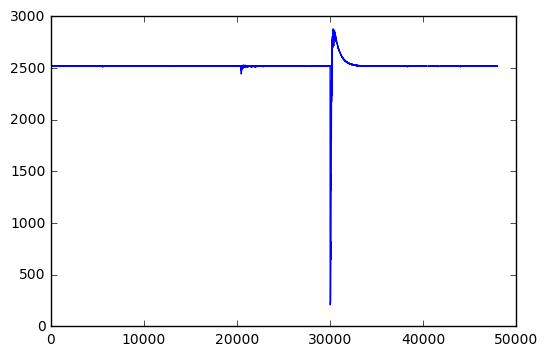

In [32]:
plt.plot(pmtcwf[621][0])
#plt.xlim((29000,33000))

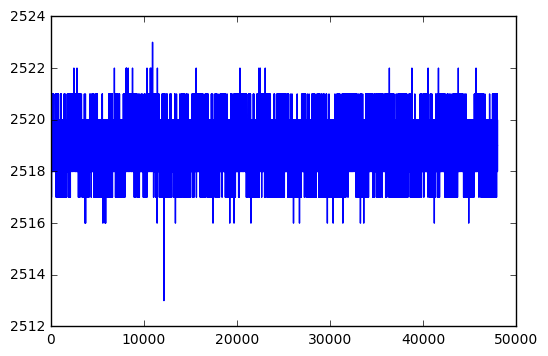

In [34]:
plt.plot(pmtcwf[0][0])